In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
from scipy import signal
from IPython.display import display, Math, Image

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [3]:
dir = "C:/Users/Marc/Documents/stage_m2/stage_m2/plots/TESS_18_19/"

<IPython.core.display.Javascript object>


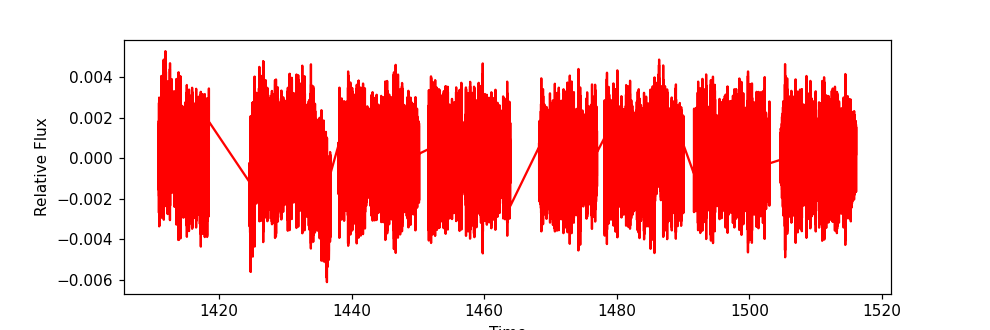

In [175]:
### TESS data import ###
data = np.loadtxt("TESS_data_all.dat",usecols=(0,1))
time = data[:,0]
index = np.argwhere((time))
# index = np.argwhere((time>1504)&(time<1517))
time = np.ndarray.flatten(time[index])
# à prendre vers 1472
flux = data[:,1]
flux = np.ndarray.flatten(flux[index])


fig = plt.figure(figsize=(9,3))
ax = plt.gca()
#ax.scatter(time,flux,c="r",s=1)
ax.plot(time,flux,c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Relative Flux")
fig.show()

In [5]:
freqs,amps,phases = np.loadtxt("TESS_freqs.txt",usecols=(1,2,3)).T
freqs_errors,amps_errors,phases_errors = np.loadtxt("TESS_freqs_errors.txt",usecols=(0,1,2)).T

In [6]:
# y = []
# y_error = []
# for i in time:
#     tmp = [] #saves one sine
#     tmp_error = []
#     for freq, amp, phase,freq_error,amp_error,phase_error in zip(freqs, amps, phases,freqs_errors, amps_errors, phases_errors):
# #    for freq_error,amp_error,phase_error in zip(freqs_errors, amps_errors, phases_errors):
#         tmp.append(amp * np.sin(2 * np.pi * freq * i + phase * 2 * np.pi))
#         tmp_error.append((amp+amp_error) * np.sin(2 * np.pi * (freq+freq_error) * i + (phase+phase_error) * 2 * np.pi))
#     y.append(np.sum(tmp))
#     y_error.append(np.sum(tmp_error))
# y = np.array(y)
# flux_error = np.array(y_error)

# y = (y - np.mean(y))/(np.max(y) - np.mean(y))
# flux_error = (flux_error - np.mean(flux_error))/(np.max(flux_error) - np.mean(flux_error))
# flux_error = y - flux_error

In [7]:
# plt.figure(figsize=(9,3))
# plt.plot(time,flux-flux_error)
# plt.show()

In [176]:
### GP Model ###
bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=1., log_Q=2.5, log_omega0=5.80,bounds=bounds)


gp = celerite.GP(kernel,mean=np.mean(flux))
gp.compute(time,yerr=4.55e-5)


print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -202829.20545312882
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])



In [9]:
x = np.linspace(np.min(time),np.max(time),15000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


In [10]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.show()

<IPython.core.display.Javascript object>

In [177]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: -433379.67182033276
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.132782  ,   9.12114047, 112.39899322])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 128
      nit: 17
   status: 0
  success: True
        x: array([-20.51439992,   1.72069738,   5.73844224])
Final log-likelihood: 433379.67182033276
[1.23227976e-09 5.58842438e+00 3.10580224e+02]
Parameters: OrderedDict([('kernel:log_S0', -20.51439991823358), ('kernel:log_Q', 1.7206973835883812), ('kernel:log_omega0', 5.738442249459018)])


In [12]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

In [13]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

<IPython.core.display.Javascript object>

In [92]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [93]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-30 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7)) :
        return 0
    return -np.inf

In [94]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [ ]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 15000,progress=True)
print("Finished")

Running burn-in...


100%|██████████| 1000/1000 [35:40<00:00,  2.14s/it]


Running production...


 19%|█▉        | 2827/15000 [1:37:47<7:12:50,  2.13s/it]

In [163]:
af = sampler.acceptance_fraction
print("Mean acceptance fraction:", np.mean(af))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Mean acceptance fraction: 0.6461703125
Final MCMC log likelihood: 56871.465688799755


In [19]:
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

In [20]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("Flux")
plt.ylim(np.min(flux),np.max(flux))
plt.title("GP fit after MCMC run")
plt.show()

<IPython.core.display.Javascript object>

In [21]:
### Résidus ###
pred_mean, pred_var = gp.predict(flux, time, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux - pred_mean,s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("Residuals")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


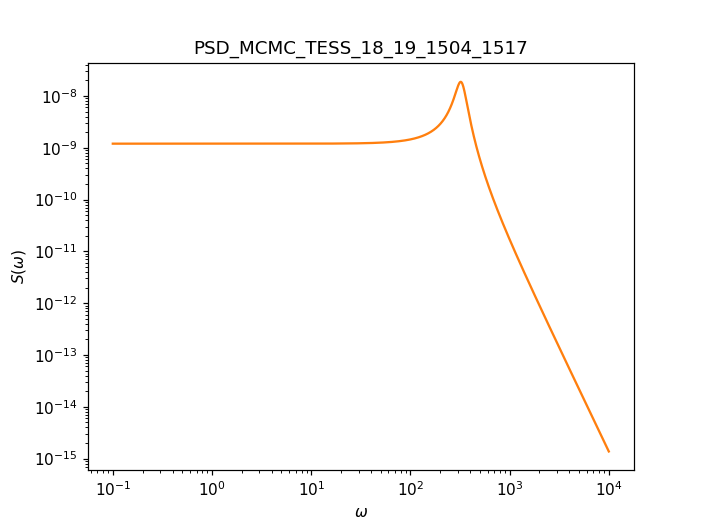

In [172]:
### PSD en fonction de omega ###
plt.figure()
color = "#ff7f0e"
omega = np.exp(np.linspace(np.log(0.1), np.log(10000), 5000))
psd = gp.kernel.get_psd(omega)
plt.plot(omega, psd, color=color)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$")
plt.title("PSD_MCMC_TESS_18_19_all")
plt.show()
plt.savefig(dir+"PSD_MCMC_TESS_18_19_all.pdf",bbox_inches='tight')

In [173]:
### Récupération des hyperparamètres et Résultats ###
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
labels = ["log(S0)","log(Q)","log(w0)"]

posteriors = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    value = np.percentile(flat_samples[:, i], [50])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    posteriors.append(value)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


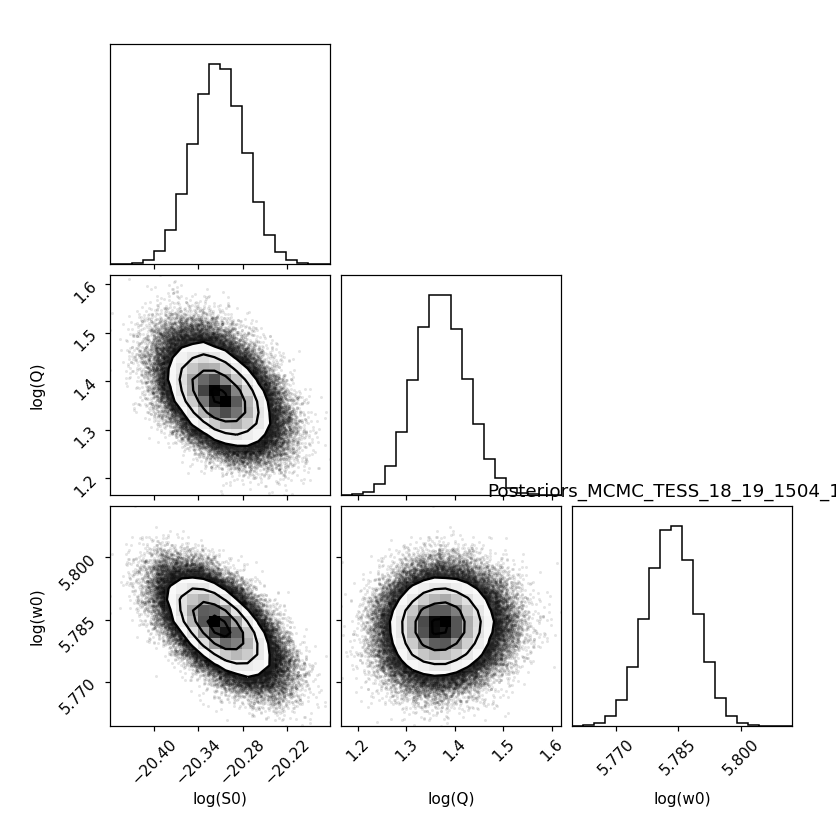

In [174]:
### Posteriors ###
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4)])
plt.title("Posteriors_MCMC_TESS_18_19_all")
plt.show()
plt.savefig(dir+"Posteriors_MCMC_TESS_18_19_all.png",bbox_inches='tight')

In [25]:
w = np.exp(posteriors[2])
f = w/(2*np.pi)
f

array([52.70167245])

In [26]:
P = 1/f
print("periode :",P*24*60,"min")

periode : [27.32361105] min


In [27]:
tau = sampler.get_autocorr_time()
print(tau)

[38.02578313 37.78330733 37.58227085]


In [28]:
### Périodogramme des résidus ###
fs = len(time)/(time[-1] - time[0])
f,pxx = signal.periodogram(flux - pred_mean,fs)
plt.figure(figsize=(9,3))
plt.plot(f,pxx)
plt.show()
idx = np.argmax(pxx)
print("freq:", f[idx],"d-1")
print("periode",1/f[idx]*60*24,"min")

<IPython.core.display.Javascript object>

freq: 346.5363054450513 d-1
periode 4.155408762007288 min


In [29]:
### Data comet ###
comet_time = data[:,0]
index = np.argwhere((comet_time>1485)&(comet_time<1489))
comet_time = np.ndarray.flatten(comet_time[index])
# à prendre vers 1472
comet_flux = data[:,1]
comet_flux = np.ndarray.flatten(comet_flux[index])

In [30]:
fig = plt.figure(figsize=(9,3))
ax = plt.gca()
#ax.scatter(time,flux,c="r",s=1)
ax.plot(comet_time,comet_flux,c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Relative Flux")
fig.show()

<IPython.core.display.Javascript object>

In [31]:
x = np.linspace(np.min(comet_time),np.max(comet_time),15000)
gp.compute(comet_time,yerr=0)
pred_mean, pred_var = gp.predict(comet_flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


In [32]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(comet_time,comet_flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(comet_flux),np.max(comet_flux))
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


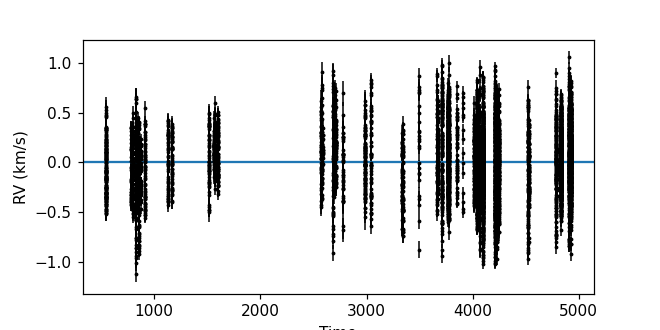

In [71]:
rv_data = np.loadtxt("rv_betapic_carine.txt",usecols=(0,1,2))
rv_time = rv_data[:,0]
rv_flux = rv_data[:,1]
rv_error = rv_data[:,2]
index = np.argwhere(rv_time)
rv_flux = np.ndarray.flatten(rv_flux[index])
rv_time = np.ndarray.flatten(rv_time[index])
rv_error = np.ndarray.flatten(rv_error[index])
plt.figure(figsize=(6,3))
plt.errorbar(rv_time,rv_flux,yerr=rv_error,markersize=3,capsize=0,fmt='.k',elinewidth=1)
plt.xlabel("Time")
plt.ylabel("RV (km/s)")
plt.savefig(dir+"RV_data_all.pdf",bbox_inches='tight')
plt.axhline(0)
plt.show()

<IPython.core.display.Javascript object>


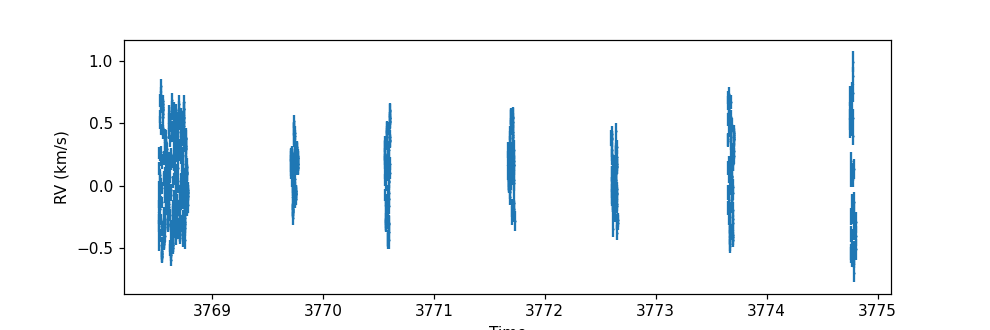

In [63]:
index = np.argwhere((rv_time>3760)&(rv_time<3778))
rv_flux = np.ndarray.flatten(rv_flux[index])
rv_time = np.ndarray.flatten(rv_time[index])
rv_error = np.ndarray.flatten(rv_error[index])
plt.figure(figsize=(9,3))
plt.errorbar(rv_time,rv_flux,yerr=rv_error,markersize=1,capsize=0,fmt='.')
plt.xlabel("Time")
plt.ylabel("RV (km/s)")
plt.savefig(dir+"RV_data.pdf",bbox_inches='tight')
plt.show()

In [72]:
def log_likelihood(params,time,flux):
        gp.set_parameter_vector(params)
        ll = gp.log_likelihood(flux)
        return ll if np.isfinite(ll) else -np.inf

### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-20 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7) and (-100 < params[3] < 100)) :
        return 0
    return -np.inf

### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

    ### MCMC ###
def run_mcmc(time,flux,gp) :
    initial = gp.get_parameter_vector()
    ndim, nwalkers = len(initial), 128
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

    print("Running burn-in...")
    p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
    p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

    print("Running production...")
    sampler.reset()
    sampler.run_mcmc(p0, 5000,progress=True)
    print("Finished")
    
    likelihood = gp.log_likelihood(flux)
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))
    return(sampler,likelihood)

In [73]:
def gp_building(posteriors,time,error) :
    bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
    #kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
    kernel = terms.SHOTerm(log_S0=posteriors[0], log_Q=posteriors[1], log_omega0=posteriors[2],bounds=bounds)


    gp = celerite.GP(kernel,fit_mean=True)
    gp.compute(time,yerr=error)

    print("Initial log likelihood: {0}".format(gp.log_likelihood(rv_flux)))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    
    return gp

In [44]:
file = open("res_TESS_18_19_RV_single_obs.txt",'w')
file.write("Borne_inf Borne_sup Likelihood log(S0) log(Q) log(w0) Offset Errors_inf S0,Q,w0,Offset Errors_sup S0,Q,w0,Offset\n")
file.close()

In [66]:
rv_data = np.loadtxt("rv_betapic_carine.txt",usecols=(0,1,2))

bnds = np.array([3320,3340,3492,3494,3666,3668,3711,3712,3713,3768,3769,3770,3771,3772,3773,3774,3849,3905,4007,4035,4036,4038,4039,4060,4093,4094,4095,4206,4207,4208,4226,4227,4228,4229,4230,4231,4238,4239,4242,4243,4244,4525,4786,4787,4789,4827,4828,4829,4905,4906,4908,4909,4921,4922,4923,4924])
# bnds = np.array([3320,3492])
file = open("res_TESS_18_19_RV_single_obs.txt",'a')
# bnds = np.array([4206,4209])
for j in range(len(bnds)-1) :
    print(j)
    rv_time = rv_data[:,0]
    rv_flux = rv_data[:,1]
    rv_error = rv_data[:,2]
    index = np.argwhere(rv_time>=3333)
    rv_flux = np.ndarray.flatten(rv_flux[index])
    rv_time = np.ndarray.flatten(rv_time[index])
    rv_error = np.ndarray.flatten(rv_error[index])
    
    ### Data à traiter ###
    index = np.argwhere((rv_time>bnds[j])&(rv_time<bnds[j+1]))
    rv_flux = np.ndarray.flatten(rv_flux[index])
    index = np.argwhere((rv_time>bnds[j])&(rv_time<bnds[j+1]))
    rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
    rv_error = np.ndarray.flatten(rv_error[index])

    gp = gp_building(posteriors,rv_time,rv_error)


    sampler,likelihood = run_mcmc(rv_time,rv_flux,gp)

    ## Posteriors ###
    
    flat_samples = sampler.get_chain(discard = 500, flat=True)
    labels = ["log(S0)","log(Q)","log(w0)","Offset"]

    rv_posteriors = np.array([])
    rv_posteriors_errors = np.array([])
    corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4),None])
    plt.title("Posteriors_MCMC_RV_%s_%s_TESS_18_19"%(bnds[j],bnds[j+1]))
    plt.savefig(dir+"obs/Posteriors_MCMC_RV_%s_%s_TESS_18_19.pdf"%(bnds[j],bnds[j+1]),bbox_inches='tight')
    plt.close()  
    
    
    not_flat_samplers = sampler.get_chain(discard = 500, flat=False)
    fig,ax = plt.subplots(2,2)
    for i in range(not_flat_samplers.shape[2]) :
        for cpt in range(2) :
            for cpt_1 in range(2) :
                if cpt == 0 :
                    ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1)],linewidth=0.5)
                    ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1)])
                if cpt == 1 :
                    ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1+1)],linewidth=0.5)
                    ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1+1)])
                    
    plt.savefig(dir+"obs/Samplers_MCMC_RV_%s_%s_TESS_18_19.pdf"%(bnds[j],bnds[j+1]),bbox_inches='tight')
    plt.close() 
    
    x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
    pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    plt.figure()
    plt.scatter(rv_time,rv_flux,s=1)
    plt.plot(x, pred_mean, color=color)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(np.min(rv_flux),np.max(rv_flux))
    plt.title("Fit_MCMC_RV_%s_%s_TESS_18_19"%(bnds[j],bnds[j+1]))
    plt.savefig(dir+"obs/Fit_MCMC_RV_%s_%s_TESS_18_19.pdf"%(bnds[j],bnds[j+1]),bbox_inches='tight')
    plt.close() 

    for i in range(flat_samples.shape[1]):

        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        value = np.percentile(flat_samples[:, i], [50])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
        rv_posteriors = np.append(rv_posteriors,value)
        rv_posteriors_errors = np.append(rv_posteriors_errors,q)
        
    w = np.exp(rv_posteriors[2])
    print(w)
    f = w/(2*np.pi)
    f
    P = 1/f
    
    results = np.array([])
    results = np.append(results,bnds[j])
    results = np.append(results,bnds[j+1])
    results = np.append(results,likelihood)
    results = np.append(results,rv_posteriors)
    results = np.append(results,rv_posteriors_errors)

    print("periode :",P*24*60,"min")
    np.savetxt(file,results.reshape(1, results.shape[0]))
file.close()

  1%|          | 5/500 [00:00<00:10, 48.54it/s]

0
Initial log likelihood: -947.897991895659
parameter_dict:
OrderedDict([('kernel:log_S0', -19.81), ('kernel:log_Q', 0.87), ('kernel:log_omega0', 5.8), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:51, 44.64it/s]

Running production...


100%|██████████| 5000/5000 [01:39<00:00, 50.38it/s]

Finished
parameter_dict:
OrderedDict([('kernel:log_S0', -10.999321352286822), ('kernel:log_Q', 3.387386064078286), ('kernel:log_omega0', 5.683115622367561), ('mean:value', -0.06122667728163917)])

Final MCMC log likelihood: 72.2498429519875


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

298.3884627589661
periode : 30.322173849085033 min


In [46]:
# rv_time = rv_data[:,0]
# rv_flux = rv_data[:,1]
# rv_error = rv_data[:,2]
# index = np.argwhere(rv_time>=3333)
# rv_flux = np.ndarray.flatten(rv_flux[index])
# rv_time = np.ndarray.flatten(rv_time[index])
# rv_error = np.ndarray.flatten(rv_error[index])

# color = "#ff7f0e"

# index = np.argwhere((rv_time>3333)&(rv_time<3492))
# rv_flux = np.ndarray.flatten(rv_flux[index])
# index = np.argwhere((rv_time>3333)&(rv_time<3492))
# rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
# rv_error = np.ndarray.flatten(rv_error[index])

# x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
# pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
# pred_std = np.sqrt(pred_var)
# plt.figure()
# plt.subplot(2,1,1)
# index1 = np.ndarray.flatten(np.argwhere((rv_time>3333) & (rv_time<3335)))
# indexx = np.ndarray.flatten(np.argwhere((x>3333) & (x<3335)))
# plt.scatter(rv_time[index1],rv_flux[index1],s=1)
# plt.plot(x[indexx], pred_mean[indexx], color=color)
# plt.fill_between(x[indexx], pred_mean[indexx]+pred_std[indexx], pred_mean[indexx]-pred_std[indexx], color=color, alpha=0.3, edgecolor="none",interpolate=True)
# plt.xlabel("x")
# plt.ylabel("y")
# plt.ylim(np.min(rv_flux),np.max(rv_flux))
# rv_time = rv_data[:,0]
# rv_flux = rv_data[:,1]
# rv_error = rv_data[:,2]
# index = np.argwhere(rv_time>=3333)
# rv_flux = np.ndarray.flatten(rv_flux[index])
# rv_time = np.ndarray.flatten(rv_time[index])
# rv_error = np.ndarray.flatten(rv_error[index])
# color = "#ff7f0e"
# plt.subplot(2,1,2)
# index1 = np.ndarray.flatten(np.argwhere((rv_time>3344) & (rv_time<3345)))
# indexx = np.ndarray.flatten(np.argwhere((x>3344) & (x<3345)))
# plt.scatter(rv_time[index1],rv_flux[index1],s=1)
# plt.plot(x[indexx], pred_mean[indexx], color=color)
# plt.fill_between(x[indexx], pred_mean[indexx]+pred_std[indexx], pred_mean[indexx]-pred_std[indexx], color=color, alpha=0.3, edgecolor="none",interpolate=True)
# plt.xlabel("x")
# plt.ylabel("y")
# plt.ylim(np.min(rv_flux),np.max(rv_flux))
# plt.title("Fit_MCMC_RV_%s_%s_TESS_18_19"%(bnds[j],bnds[j+1]))
# plt.show()
# plt.savefig(dir+"obs/Fit_MCMC_RV_%s_%s_TESS_18_19.pdf"%(bnds[j],bnds[j+1]),bbox_inches='tight')
# # plt.close() 

In [47]:
# rv_time = rv_data[:,0]
# rv_flux = rv_data[:,1]
# rv_error = rv_data[:,2]
# index = np.argwhere(rv_time>=3333)
# rv_flux = np.ndarray.flatten(rv_flux[index])
# rv_time = np.ndarray.flatten(rv_time[index])
# rv_error = np.ndarray.flatten(rv_error[index])

# ### Data à traiter ###
# index = np.argwhere((rv_time>4206)&(rv_time<4209))
# rv_flux = np.ndarray.flatten(rv_flux[index])
# index = np.argwhere((rv_time>4206)&(rv_time<4209))
# rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
# rv_error = np.ndarray.flatten(rv_error[index])
    


In [48]:
file = open("res_TESS_18_19_RV_groups_moy_single_obs.txt",'w')
file.write("Borne_inf Borne_sup log(S0) log(Q) log(w0) Offset Errors_inf S0,Q,w0,Offset Errors_sup S0,Q,w0,Offset\n")
file.close()

In [49]:
results_data = np.loadtxt("res_TESS_18_19_RV_single_obs.txt",usecols=(3,4,5,6,7,8,9,10,11,12,13,14),skiprows=1)
bnds = np.array([3320,3340,3492,3494,3666,3668,3711,3712,3713,3768,3769,3770,3771,3772,3773,3774,3849,3905,4007,4035,4036,4038,4039,4060,4093,4094,4095,4206,4207,4208,4226,4227,4228,4229,4230,4231,4238,4239,4242,4243,4244,4525,4786,4787,4789,4827,4828,4829,4905,4906,4908,4909,4921,4922,4923,4924])
groups_bnds = np.array([3320,3340,3492,3666,3711,3768,3849,3905,4007,4035,4060,4093,4206,4226,4238,4525,4786,4827,4905,4921,4924])
indexes = np.array([])
file = open("res_TESS_18_19_RV_groups_moy_single_obs.txt",'a')
for i in range(len(groups_bnds)) :
    index = np.argwhere(groups_bnds[i] == bnds)
    indexes = np.append(indexes,index)
    
indexes = np.ndarray.flatten(np.array(indexes)).astype(int)


for i in range(len(indexes)-1) :
    moyenne = np.mean(results_data[indexes[i]:indexes[i+1],0:3],axis=0)
    moyenne_errors = np.mean(results_data[indexes[i]:indexes[i+1],3:],axis=0)
    results = np.array([])
    results = np.append(results,bnds[indexes[i]])
    results = np.append(results,bnds[indexes[i+1]])
    results = np.append(results,0)
    results = np.append(results,moyenne)
    results = np.append(results,moyenne_errors)
    np.savetxt(file,results.reshape(1, results.shape[0]))
file.close()

In [53]:
file = open("res_TESS_18_19_RV_groups_obs.txt",'w')
file.write("Borne_inf Borne_sup Likelihood log(S0) log(Q) log(w0) Offset Errors_inf S0,Q,w0,Offset Errors_sup S0,Q,w0,Offset\n")
file.close()

In [64]:
rv_data = np.loadtxt("rv_betapic_carine.txt",usecols=(0,1,2))

groups_bnds = np.array([3320,3340,3492,3666,3711,3768,3849,3905,4007,4035,4060,4093,4206,4226,4238,4525,4786,4827,4905,4921,4924])
file = open("res_TESS_18_19_RV_groups_obs.txt",'a')
for j in range(len(groups_bnds)-1) :
    print(j)
    rv_time = rv_data[:,0]
    rv_flux = rv_data[:,1]
    rv_error = rv_data[:,2]
    index = np.argwhere(rv_time>=3333)
    rv_flux = np.ndarray.flatten(rv_flux[index])
    rv_time = np.ndarray.flatten(rv_time[index])
    rv_error = np.ndarray.flatten(rv_error[index])
    
    
    ### Data à traiter ###
    index = np.argwhere((rv_time>groups_bnds[j])&(rv_time<groups_bnds[j+1]))
    rv_flux = np.ndarray.flatten(rv_flux[index])
    index = np.argwhere((rv_time>groups_bnds[j])&(rv_time<groups_bnds[j+1]))
    rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
    rv_error = np.ndarray.flatten(rv_error[index])
    
    gp = gp_building(posteriors,rv_time,rv_error)


    sampler,likelihood = run_mcmc(rv_time,rv_flux,gp)

    ## Posteriors ###
    flat_samples = sampler.get_chain(flat=True)
    labels = ["log(S0)","log(Q)","log(w0)","Offset"]

    rv_posteriors = np.array([])
    rv_posteriors_errors = np.array([])
    fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4),None])
    plt.title("Posteriors_MCMC_grp_RV_%s_%s_TESS_18_19"%(groups_bnds[j],groups_bnds[j+1]))
    plt.savefig(dir+"grp/Posteriors_MCMC_grp_RV_%s_%s_TESS_18_19.pdf"%(groups_bnds[j],groups_bnds[j+1]),bbox_inches='tight')
    plt.close()  
    
    
    not_flat_samplers = sampler.get_chain(flat=False)
    fig,ax = plt.subplots(2,2)
    for i in range(not_flat_samplers.shape[2]) :
        for cpt in range(2) :
            for cpt_1 in range(2) :
                if cpt == 0 :
                    ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1)],linewidth=0.5)
                    ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1)])
                if cpt == 1 :
                    ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1+1)],linewidth=0.5)
                    ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1+1)])
                    
    plt.savefig(dir+"grp/Samplers_MCMC_grp_RV_%s_%s_TESS_18_19.pdf"%(groups_bnds[j],groups_bnds[j+1]),bbox_inches='tight')
    plt.close() 
    
    
    x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
    pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    plt.figure()
    plt.scatter(rv_time,rv_flux,s=1)
    plt.plot(x, pred_mean, color=color)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(np.min(rv_flux),np.max(rv_flux))
    plt.title("Fit_MCMC_grp_RV_%s_%s_TESS_18_19"%(groups_bnds[j],groups_bnds[j+1]))
    plt.savefig(dir+"grp/Fit_MCMC_grp_RV_%s_%s_TESS_18_19.pdf"%(groups_bnds[j],groups_bnds[j+1]),bbox_inches='tight')
    plt.close() 

    for i in range(flat_samples.shape[1]):

        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        value = np.percentile(flat_samples[:, i], [50])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
        rv_posteriors = np.append(rv_posteriors,value)
        rv_posteriors_errors = np.append(rv_posteriors_errors,q)
        
    w = np.exp(rv_posteriors[2])
    print(w)
    f = w/(2*np.pi)
    f
    P = 1/f
    
    results = np.array([])
    results = np.append(results,groups_bnds[j])
    results = np.append(results,groups_bnds[j+1])
    results = np.append(results,likelihood)
    results = np.append(results,rv_posteriors)
    results = np.append(results,rv_posteriors_errors)

    print("periode :",P*24*60,"min")
    np.savetxt(file,results.reshape(1, results.shape[0]))
file.close()

  0%|          | 0/500 [00:00<?, ?it/s]

0
Initial log likelihood: -338.7498191750889
parameter_dict:
OrderedDict([('kernel:log_S0', -19.81), ('kernel:log_Q', 0.87), ('kernel:log_omega0', 5.8), ('mean:value', 0.0)])

Running burn-in...


 96%|█████████▌| 478/500 [00:08<00:00, 54.86it/s]Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\emcee\ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-34-19b551f4a647>", line 23, in log_probability
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf
  File "<ipython-input-34-19b551f4a647>", line 9, in log_likelihood
    ll = gp.log_likelihood(flux)
  File "C:\ProgramData\Anaconda3\lib\site-packages\celerite\celerite.py", line 204, in log_likelihood
    self._recompute()
  File "C:\ProgramData\Anaconda3\lib\site-packages\celerite\celerite.py", line 170, in _recompute
    V=self._V,
  File "C:\ProgramData\Anaconda3\lib\site-packages\celerite\celerite.py", line 156, in compute
    self._yerr ** 2,
KeyboardInterrupt
 96%|█████████▌| 481/500 [00:08<00:00, 56.16it/s]

emcee: Exception while calling your likelihood function:
  params: [ 4.37350592 -7.64894982  6.26706814  0.46105213]
  args: (array([3333.856444, 3333.857022, 3333.857613, 3333.858203, 3333.858805,
       3333.859383, 3333.859974, 3333.860576, 3333.861154, 3333.861745,
       3333.862346, 3333.862937, 3333.863515, 3333.864117, 3333.864708,
       3333.865298, 3333.865877, 3333.866467, 3333.867069, 3333.867647,
       3333.868238, 3333.86884 , 3333.869418, 3333.87002 , 3333.870599,
       3333.871201, 3333.871791, 3333.87237 , 3333.872972, 3333.873562,
       3333.874152, 3333.874731, 3333.875344, 3333.875935, 3333.876513,
       3333.877115, 3333.877694, 3333.878284, 3333.878886, 3333.879465,
       3333.880067, 3333.880645, 3333.881247, 3333.881826, 3333.882416,
       3333.883007, 3333.883608, 3333.884187, 3333.884789, 3333.885379]), array([-0.225427, -0.128215, -0.14757 , -0.110674, -0.240944, -0.376447,
       -0.325701, -0.377505, -0.365567, -0.582803, -0.374232, -0.385567,
      

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


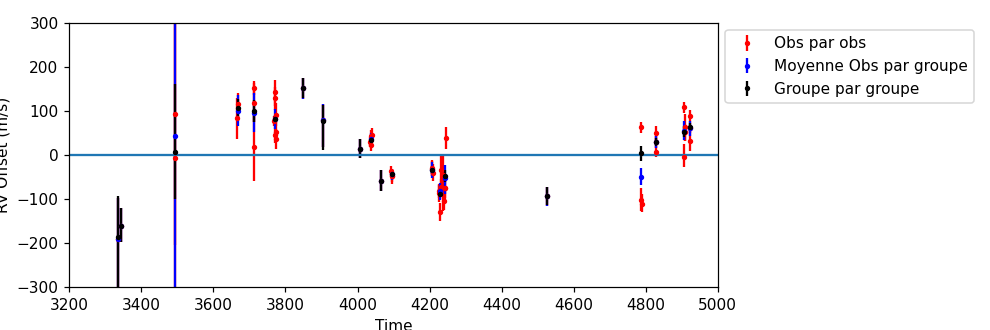

In [68]:
rv_time = rv_data[:,0]
index = np.argwhere(rv_time>=3333)
rv_time = np.ndarray.flatten(rv_time[index])
results = np.loadtxt("res_TESS_18_19_RV_single_obs.txt",usecols=(0,1,6,13,14),skiprows=1)
groups_moy_results = np.loadtxt("res_TESS_18_19_RV_groups_moy_single_obs.txt",usecols=(0,1,6,13,14),skiprows=1)
groups_results = np.loadtxt("res_TESS_18_19_RV_groups_obs.txt",usecols=(0,1,6,13,14),skiprows=1)
plt.figure(figsize=(9,3))
rv_time_plot_obs = np.array([])
rv_time_plot_grp = np.array([])
for i in range(len(results)) :
    mean_time_obs = np.mean(rv_time[np.argwhere((rv_time>results[i][0])&(rv_time<results[i][1]))])   
    rv_time_plot_obs = np.append(rv_time_plot_obs,mean_time_obs)
    
for j in range(len(groups_results)) :
    mean_time_grp = np.mean(rv_time[np.argwhere((rv_time>groups_results[j][0])&(rv_time<groups_results[j][1]))])
    rv_time_plot_grp = np.append(rv_time_plot_grp,mean_time_grp)
    
plt.errorbar(rv_time_plot_obs,results[:,2]*1000,yerr=[results[:,3]*1000,results[:,4]*1000],fmt='.r',markersize=5,capsize=0,label="Obs par obs")
plt.errorbar(rv_time_plot_grp,groups_moy_results[:,2]*1000,yerr=[groups_moy_results[:,3]*1000,groups_moy_results[:,4]*1000],fmt='.b',markersize=5,capsize=0,label="Moyenne Obs par groupe")
plt.errorbar(rv_time_plot_grp,groups_results[:,2]*1000,yerr=[groups_results[:,3]*1000,groups_results[:,4]*1000],fmt='.k',markersize=5,capsize=0,label="Groupe par groupe")
plt.xlim(3200,5000)
plt.ylim(-300,300)
plt.legend(bbox_to_anchor=(1.,1.),loc='upper left')
plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("RV Offset (m/s)")
plt.axhline(0)
plt.savefig(dir+"Offsets_RV_18_19.pdf",bbox_inches="tight")
plt.show()